In [1]:
import numpy as np
import control as ct
from planar_quad import PlanarQuad
import matplotlib.pyplot as plt

In [2]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
# Start with a diagonal weighting
Q_ctrl = np.array([[1e0, 0., 0., 0., 0., 0.],
                           [0., 1e0, 0., 0., 0., 0.],
                           [0., 0., 1e0, 0., 0., 0.],
                           [0., 0., 0., 1e0, 0., 0.],
                           [0., 0., 0., 0., 1e0, 0.],
                           [0., 0., 0., 0., 0., 1e0]])

R_ctrl = np.array([[1e1, 0.],
                           [0., 1e1]])

K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

Q_est = np.eye(6)
R_est = np.eye(2)

L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

A_delta = np.block([[A-B@K, B@K, np.zeros((6,6))], 
                   [np.zeros((6,6)), A-L@C@A, np.zeros((6,6))],
                   [np.zeros((6,6)), np.zeros((6,6)), (np.eye(6) - L@C)@A - B@K]])

B_delta = np.block([[np.zeros((6,2))],
                    [-L@np.eye(2)],
                    [L@np.eye(2)]
                    ])
W_delta = np.block([[np.eye(6), np.zeros((6,2))],
                    [(np.eye(6) - L@C), -L],
                    [np.zeros((6,6)),np.zeros((6,2))]])

C_tilde = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
C_delta = np.block([[C_tilde,np.zeros((2,6)),np.zeros((2,6))],
                    [np.zeros((2,6)),np.zeros((2,6)),C_tilde]])
M = np.block([np.zeros((2,6)),np.zeros((2,6)),-C])
Q_delta_est = np.eye(18)
R_delta_est = np.eye(4)
Lo, _, _ = ct.dlqe(A_delta, np.eye(18), C_delta, Q_delta_est, R_delta_est) 

Text(0.5, 0, 'Time [s]')

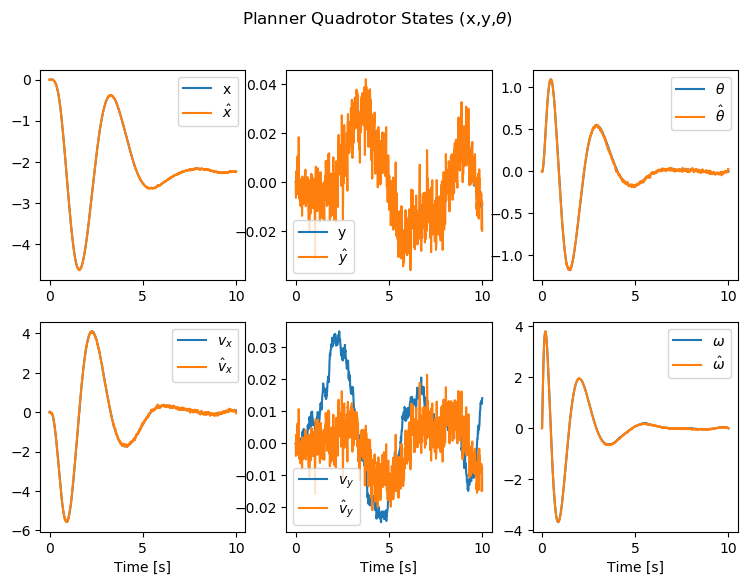

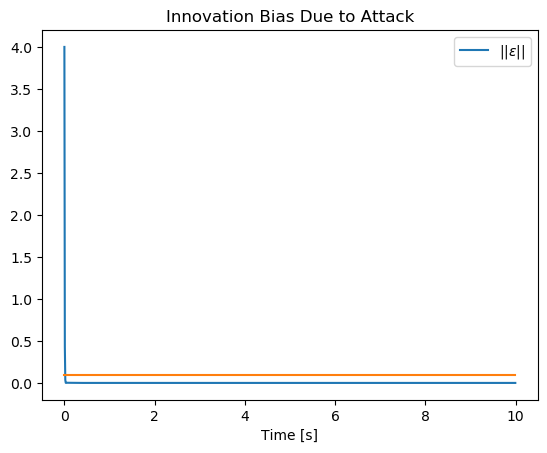

In [4]:
T =1000
t = np.zeros([T+1,])
x0 = np.array([0, 0., 0., 0., 0, 0.])
x0_est = np.array([0.0, 0., 0., 0., 0, 0.])

eta = np.empty([18, T+1])
eta_est = np.empty([18, T+1])
epsilon = np.empty([2, T])

eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])
eta_est[:,0] = np.block([x0_est, np.zeros(6), np.zeros(6)])
epsilon[:,0] = np.zeros(2)
a = np.array([2.0, 0.0])

for i in range(T):
    w = 0.001*np.random.randn(6,1)
    v = 0.001*np.random.randn(2,1)
    w_tilde = np.block([[w],[v]]).reshape((8,))
    epsilon[:,i] = M@eta[:,i] + a
    eta[:,i+1] = A_delta@eta[:,i] + B_delta@a + W_delta@w_tilde
    v = 0.01*np.random.randn(4)
    y = C_delta@eta[:,i+1] + v
    eta_est[:,i+1] = A_delta@eta_est[:,i] + B_delta@a + Lo@(y - C_delta@A_delta@eta_est[:,i])
    t[i+1] = t[i] + 0.01
state = eta[:6,:] 
state_est = eta_est[:6,:] 

plt.figure(figsize=[9,6])
plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_est[0,:])
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_est[2,:])
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_est[4,:])
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_est[1,:])
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_est[3,:])
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_est[5,:])
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.title('Innovation Bias Due to Attack')
plt.plot(t[:-1], np.linalg.norm(epsilon[:,:], axis=0)**2) 
plt.plot(t[:-1], np.repeat(0.1, t.shape[0]-1))
plt.legend(['$||{\epsilon}||$'])
plt.xlabel('Time [s]')


In [5]:
import cvxpy as cp
from scipy.linalg import sqrtm

def solve_lmi(A, B, eta, r_max=1, n_states=6, verbose=False):
    ## M Kothare LMI Implementation for constant reference tracking
    n = n_states*3 # Augmented state dim
    m = B.shape[1] # Attack vector dim
    Q = cp.Variable((n,n), PSD=True)
    Y = cp.Variable((m,n))

    gamma = cp.Variable()
    
    T_1 = np.zeros((6,6))
    T_1[0,0] = 1
    T_1[2,2] = 1
    T_1[4,4] = 1
    T = np.block([T_1, np.zeros((6,6)),np.zeros((6,6))])

    M_3 = np.zeros((6,6))
    M_3[0,0] = 1
    M_3[2,2] = 1
    M_3[4,4] = 0
    M = np.block([np.zeros((6,6)),np.zeros((6,6)), M_3])
    #M = np.block([np.zeros((6,6)),np.zeros((6,6)), np.eye(6)])
    Q_curly = 1e2*(T.T@np.eye(n_states)@T)
    #Q_curly = 1e3*np.eye(n)
    block_eq1 = cp.bmat([
        [Q, Q@A.T+Y.T@B.T, Q@sqrtm(Q_curly)],
        [A@Q+B@Y,  Q,  np.zeros((n,n))],
        [sqrtm(Q_curly)@Q,np.zeros((n,n)), gamma*np.eye(n)]])
    
    block_eq2 = cp.bmat([
        [np.eye(1), eta.T],
        [eta,Q]])
    
    block_eq3 = cp.bmat([
        [Q, (A@Q+B@Y).T@M.T],
        [M@(A@Q+B@Y), r_max**2*np.eye(n_states)]])
    
    const = [block_eq1 >> 0, block_eq2>>0, block_eq3>>0]
    prob = cp.Problem(cp.Minimize(gamma), constraints = const)
    try:
        prob.solve(solver = cp.MOSEK, verbose=verbose)
        cost = gamma.value
    except Exception as e:
        print(e)
        cost = -1       
    return {
        'cost': cost,
        'F': np.round(np.array(Y.value @ np.linalg.inv(Q.value)), 3),
        'Q': np.round(np.array(Q.value), 3),
        'gamma': gamma.value
    }

res = solve_lmi(A_delta, B_delta, np.zeros((18,1)),  n_states=6)

In [570]:
N =200
t = np.zeros([N+1,])
x0 = np.array([0.0, 0., 0., 0., 0, 0.])

eta = np.empty([18, N+1])
eta_est = np.empty([18, N+1])
a = np.empty([2, N+1])

eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])
eta_est[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])

eta_test = np.empty([18, N+1])
eta_test[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])


eta_star = np.zeros((18,))
eta_star[0] = -1.2
eta_star[2] = -1.2


gamma = np.zeros([N,])

a[:,0] = np.array([0.0,0.0])
r_max = 15


for i in range(N):
    w = 0.01*np.random.randn(6)
    v = 0.01*np.random.randn(2)
    w_tilde = np.block([w,v])
    print(i, a[:,i], res['gamma'])

    eta[:,i+1] = eta_star + A_delta@(eta[:,i] - eta_star) + B_delta@(a[:,i])+ W_delta@w_tilde
    t[i+1] = t[i] + 0.01
    
    err = eta[:,i+1] - eta_star
    res = solve_lmi(A_delta, B_delta, np.reshape(err,(18,1)), r_max, n_states=6, verbose = False)
    F_obs = res['F']
    gamma[i] = res['gamma']

    a[:,i+1] = F_obs@(eta[:,i+1] - eta_star)
    eta_test[:,i+1] =  A_delta@eta_test[:,i] + B_delta@(a[:,i])+ (np.eye(18) - A_delta)@eta_star + W_delta@w_tilde
   

# state = eta[:6,:] 
# delta = eta[12:,:]


state = eta_test[:6,:] 
delta = eta_test[12:,:]

0 [0. 0.] 6.941621811237523e-09
1 [ 8.61744606 16.4451533 ] 11678.852694665737
2 [ 4.64529438 10.37152638] 11048.269648122468
3 [ 4.20614114 10.1830417 ] 10772.453714367482
4 [3.80674965 9.84690463] 10715.40955912823
5 [3.21350227 9.64908567] 10327.06761230597
6 [2.90724868 9.36453313] 10090.57748748345
7 [2.17235429 9.01514734] 9617.409976866738
8 [1.41753162 8.60888457] 9020.551886656518
9 [1.14357051 8.26450879] 8598.668205665377


KeyboardInterrupt: 

6 [-1.2, -1.2]


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAIA9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DIBliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKYNX0WHAAAAD
AAmgAVAAowCUgKXjPS4pInAAnJJLev3ef0KpRN4oqVhUxSPScpUmpxwi08gGUwxaRfE5/w94JDuC
7fS/csxbkfv8RkaPYS/FXPwIeABZ9koF/wxxDWd5dj7iYZYxa3RZZltRF2K21/EHSwLLNaQppE37
V2wAoYHwkX/ewu/aWiiTilcQTvnjhPhST6vWZNJKJDLmw5HDyhr6avqb1vHjjfwIzXhM865bPohH
bWJ89sncdvPgvUQAaTjvR74cRuBOpzFWzPwJ3ZjDgJ6QojO4y3863Q09XbNmGLuACO/fyVlwE7Tm
U35wzz9kesNkM3gNfgVJzZv6fitOkT+JQ04mqYZpwXd8bhRRtMdA/9+PcRs+QeL0TUVzxrkFyw7y
iaRG2mMG5JI7oum3oM1BnRF6X9ICH6VIR6xe7aGJzAJi77jNHvYAeZ6EJUSWX3xf7JlO+dbXIgs7
nGinxTZ8g57so1Y3U8WhK3rGvQsc2M4VwdGKdWeA4HUZYhz1/sT1uQ06arxiQyMd376RyXGTBEo8
7YWSip/qRHa/gB39rHWALUSZ7rtwffLg0qhrq1ND24e0ORlhdmTUGr5HEd2N/uQE+/hzFfoBgzVQ
hM1mU+1GKBLpJR5VvNGZh5r+MMrtwp9OOgyFPqGXz5wjSDh50JogzsmcOfDMuntWuDMQAC8WOYzu
etwEJxnQ1JwwzSB6a4AQTfgdWAgrtFH0hZ+/EZrAQwJbPTy1vuIZASXykw75OfbS11K7iUmOjnGi
j5wkIVnjcJXgNXyPYJZJX5SUuPjLQFubyVZqv+e9GwqlMHNNGX7jbQVwvqF9vcLF8xDimMIQq3sX
Rc6jPxnn1WIOoMCYhtMnKPXe9wUJ+/AK2RJt2uhEJi5NYqmUNxqq5l5d934WRG5vQkbAM5daIeOt
I2X9IStk3txew38auBGVJrkDjGbO9UtxP049pcxGsgit46kVEdib/DaAu/QodmiPwT8r/rgeso9O
N5MhyLteWbxjJGykqreDMCPnoeIvIk5jzZHdRQhBOJWM9LbsNQhfLqiP+FzBw0x9icsAi9eVURxY
+/X1mzVUfEJhgABVY7qEghGElPcIK+yn5IEuMlhmMFNdLfMm6eY7pf3ldjAbkGM41EA1AIa6/hsd
BmWLzEYDW6kYEmNraSiWpdCxcN91non4/1/0p+ohX5AST0PGrfXNIxHbym4uQ09FwoN2Latg4sNC
AwiIE4h+OSZf/rw/bljCeJqJZbywGb19XBY8+Zg3AmMBH01I0ufsdlKlZbLBr6qtF6ATZ8Jarm40
9j+Cp5GKod64YrA7KFo396cZcS9RaCBuExbnywcofhjbhRRKpMzsWRV7BDZ4uyTevAxptJPJa6Vr
qqY5NHAoaH+88hIj96ZlsFKw6tX0euImT+EhaRlZ3i97i5n/iSPrtvUmIqFGTFlUtchZ5TjSZPpm
62Oi80weFqVLS/h9NrmLgovLh8zb7dlwj7VUemCKI78qz8oVpQ7EZsAKtj5HpL3RNf6qGNfE6xk8
AeAwKi/YLoh8OXi3gCKiiy39AhGc4FUcXpmIhhZr6KBPojYR7RD7c5NW6RP2kP4LnTXPsRrHvndN
/IsWIxRQihdM3zl15sITLBw0TsZRtA9cEySQLspcFArgtyItN31Ab0ZiJyEk4T/gBwZS/enWF/5x
lDGGpbhzpzQ4ABjo42PZKW2mMf/DiHeNIyC7AnAc0ZBR8CarSoHSQlLqV4kMienKGSrhRgsyM2Jz
/0W9b1S+pHo1Pkx8c5D87H0qDs5q0UyYGhteVjYNfUb62a/ctrEcQDTAv5aocPFAPFdo+GC2LcJj
nYmnwU9RQmuG41mGgVLoWq9gAAAbgeywGRu4Ej1WrrhbJ+CT6REtgNK9cznMs8PF74+a+aeHxK+M
iEQCjv02U+fKoqDOzR3oyMnhnaoiWhonjJRPVl5DQ87YJm7bTMUFAuLpfM4cSLeYkT816XsRp5b1
8gicEN47E69Xd3AsNIiZ+KtVlQXgESykBw722uQo5zOFkYEmRjITm18kDHu1QrHIEYnvxwl7iW0B
ta9RAr/WhcrJG7nJ+R46gSiseUdxEpbH5JkxpzQmRVNBT5c7PKQ0QOwZZhZOxWDHVrJuxu/Mc5tw
o2hI2km/Zjj+ADMzslGQjlEnmY/mA7G1lz7b/2YpyHY47ZmzOPZynmXE93373SR2c6xIzctCWvbC
dUINr3t1xBdESD/2IKS5gLN2J1IZ1ZAsPmAg8FrOp8C3Zp89yAFuMZdV3I9qH3BCqJ+2H8qIEZcT
xCLZ3DmStrfdP2ep3Q6yBmEt7jEPfy19TV8g7BwC09RDDvMV+ZDOMCv1dL5zMFhwfvaopqRPtIJe
U4wEaWiA+IdwI9LhzWxldTHDOvCdWWjZ3TV/irC4ZO1uQp2mHgzcKzar+b+RAZRcCRK2ZqtLg8ZL
Y83MZ36IAA4oSPuzXQ2hSm/JB/EY3/QfpiBxW8wqVfIhAcYMkxoytNLWn33GE+eJ7he6LdRIvLkT
xzyVNv896UaCEU7JLqfTBpJsXuhgARurqOxMCKmZgIb1oJchhvGJ2iuIo1aoPXghdfwldbNqI/iY
MvQ9NGN9qBJnoHUa+32HHXH9PET8quJ5U36s+ZCTmuZvXa7KRxhzqmTj5aRNwhuxsBIhtZSWhIiU
E8GpJaVVZlaMd/4j39PVQRg1sdsKYwb3BZJj/ZEIKExwQiApqF/9u2Wp2WGONvyTd6L0D5o33B0I
89C0AeIVah6sDUPv4l1tlKHbKwh+4D49FtflpdTvGYCp1WaYiiOpZlLjDZ9h6hGxJ9HW/dpi9tv/
MfXYnOYYjBMzRa+ca/Ey9

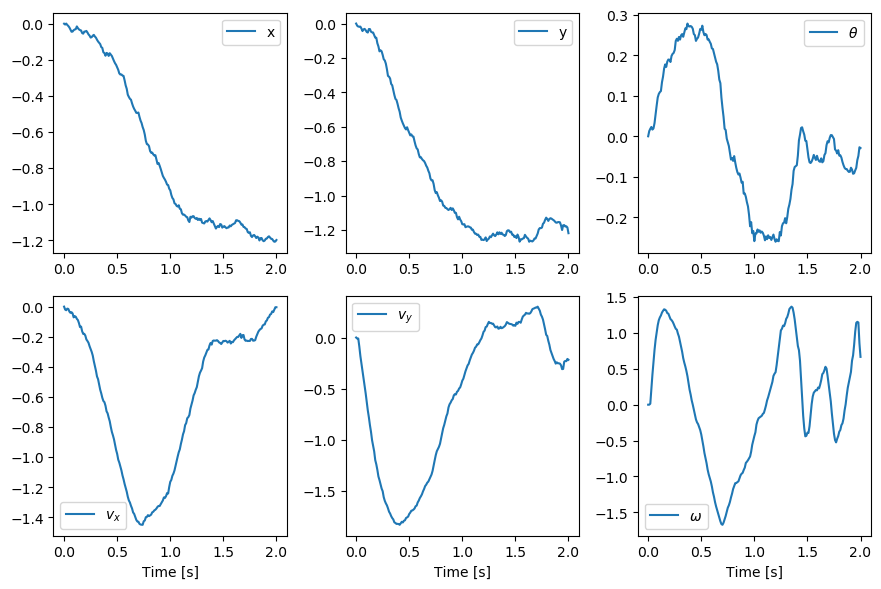

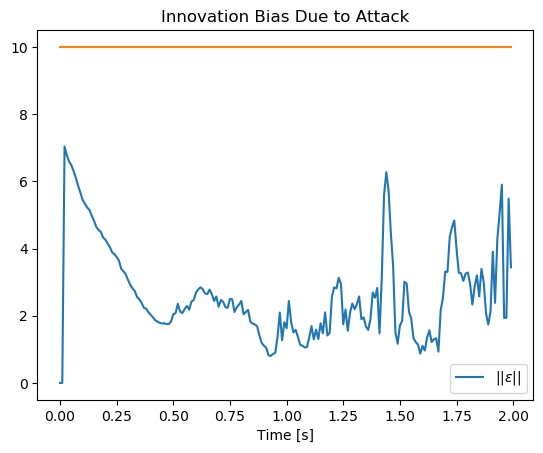

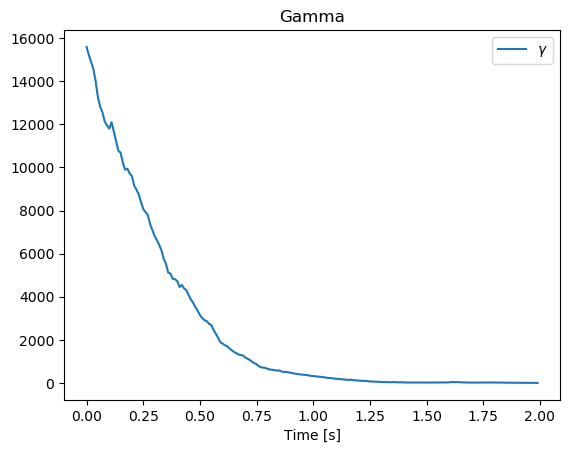

In [183]:
plt.figure(figsize=[9,6])
#plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')
plt.tight_layout()


# we can also plot the control
plt.figure()
plt.title('Innovation Bias Due to Attack')
plt.plot(t[:-1], np.linalg.norm(-delta[:,:-1], axis=0)) 
plt.plot(t[:-1], np.repeat(10, t.shape[0]-1))
plt.legend(['$||{\epsilon}||$'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.title('Gamma')
plt.plot(t[:-1], gamma) 
plt.legend(['${\gamma}$'])
plt.xlabel('Time [s]')


u = np.zeros([2, N])
quad.animate(state, u, goal=[-1.2,-1.2])

In [218]:
N =250
t = np.zeros([N+1,])
x0 = np.array([0.0, 0., 0., 0., 0, 0.])

eta = np.empty([18, N+1])
eta_est = np.empty([18, N+1])
a = np.empty([2, N+1])


eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])
eta_est[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])

delta = np.empty([6, N+1])
delta[:,0] = np.zeros(6)

a_star = np.array([2.4,0.0])
eta_star = np.zeros((18,))
eta_star[0] = a_star[0]
eta_star[2] = a_star[1]
eta_star[6] = a_star[0]
eta_star[8] = a_star[1]

gamma = np.zeros([N,])

a[:,0] = np.array([0.0,0.0])
r_max = 5.0


x0 = np.array([0.0, 0., 0., 0., 0, 0.])
x0_est = np.array([0.0, 0., 0., 0., 0, 0.])
x0_est_0 = np.array([0.0, 0., 0., 0., 0, 0.])

t = np.zeros([N+1,])
x = np.empty([6, N+1])
x_est = np.empty([6, N+1])
x[:,0] = x0
x_est[:,0] = x0_est
x_est_0 = np.empty([6, N+1])
x_est_0[:,0] = x0_est_0

A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))

for i in range(N):
    w = 0.001*np.random.randn(6)
    v = 0.1*np.random.randn(2)
    w_tilde = np.block([w,v])
    print(i, a[:,i], res['gamma'])

    eta[:,i+1] = eta_star + A_delta@(eta[:,i] - eta_star) + B_delta@(a[:,i])+ W_delta@w_tilde
    t[i+1] = t[i] + 0.01
    
    err = eta[:,i+1] - eta_star
    res = solve_lmi(A_delta, B_delta, np.reshape(err,(18,1)), r_max, n_states=6, verbose = False)
    F_obs = res['F']
    gamma[i] = res['gamma']
    a[:,i+1] = F_obs@(eta[:,i+1] - eta_star) 

    x[:,i+1] = A@x[:,i] - B@K@x_est[:,i] + w 
    y = a[:,i] + v + C@(x[:,i+1]) - a_star
    y_0 = C@x[:,i+1] + v
    
    x_est[:,i+1] = (A - B@K)@x_est[:,i] + L@(y - C@((A - B@K)@x_est[:,i]))
    x_est_0[:,i+1] = A@x_est_0[:,i] - B@K@(x_est[:,i]) + L@(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i])))
    delta[:,i+1] = ((np.eye(6) - L@C)@A - B@K)@delta[:,i] - L@(a[:,i])
    print(np.linalg.norm(y - C@((A - B@K)@x_est[:,i])))
    print(np.linalg.norm(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i]))))

state = x
state_est = x_est
state_est_0 = x_est_0

0 [0. 0.] 38828.61656303847
2.4212780873656534
0.04858880163982931
1 [-1.25438712  0.00677861] 38784.11658806527
2.1173034859530646
0.22127653820773333
2 [-0.61609925  0.00448852] 38104.66135662189
0.21057224660045679
0.06194892194680511
3 [-0.50357214  0.00593842] 37445.179902767224
0.33209835949817573
0.09439654267533659
4 [-0.35196801 -0.00542559] 36908.62627838167
0.5547776840210307
0.16781855105631943
5 [-0.24042882 -0.00759014] 36309.77295049524
0.5789640062618818
0.21706627579842877
6 [-0.12820205  0.01064118] 35719.397744955
0.13426228662909634
0.2276302994936492
7 [-0.014251    0.00569918] 35074.68830835222
0.30667073916856913
0.053100454687664826
8 [0.10529139 0.01448904] 34464.92757947934
0.4021742601736221
0.06398647450691856
9 [ 0.20704189 -0.00626823] 33806.79456298578
0.4731188219915904
0.16411417636525436
10 [0.30011694 0.01941624] 33268.62269121354
0.19778044264078118
0.18510929551031183
11 [0.41526006 0.00954661] 32643.86373692448
0.18554239903541217
0.102767720659309

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAALL5tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DOBliIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAAD
AAC3gBewDCAKqAvuW9vpD08QBwlbjn9sjqI9X7GgCKP2t9KEB9C1zvoBGpjZJax4QDCFgzzSVsgW
+1A5i2LiyXqSZPjsLEanbpCAEnK2maSAIkFha4nmSf6RDR3SOU1Jy45mkOt1yScRKqhBSrN+2CIO
puy8ePoBI8xIrLeQSNDO5Ez4G8/S6jZ/tqbOUBoTRZ50hxG4s35QTgMJ1c/VBRCawNeAol4oXyhe
TLFHdoHBobFDRsza0owgO3Yp2aPmvtbPovYxDgn6DGEmAVOc4Q/kIkXbtK5AOY2YMBOq61YW5I+/
z3Ruzdc3v0az1jJX9qpfK+fWJR+JQZ3/K3y/8g1yRPDB8gbysaQgjWG4oAxIZoB9Culh8TZDhFEh
4f2xVLr8pNQ9GcU2aZieu1y29IcG8B7kC6qavA6VX3B2HaJfU+h0eIY4ZJhH0kj12OcIwJgmDsGA
VzgI4Qo9LwVEN5inwqOzqzuFBmOiktHrUEq1j2q6n4RDUxYf+KeIMe/Irm2fPJfFwLYisPcB68MS
nJvpUSxc7KgwIugIAScFhd7juL+uUI71Sc8xkAPpmtGESREfaKsDFerorF1Ijkyb+m/C+4anTzxY
5KdADH9T2XMdv56Ss118+DF3HiAtt11C/feUXvUAJl8DozJZ/fuba+qw2UWq3b5Y5SbPz6VEnBWo
ftC+hvcHvO3FE8dngHl0bIrQAacPNFkc4AxCE2BseAMbF74GTAJRCcXD2AM5+5MiwAi++rYNwfaF
xyz0dkPAofgzggW4o1ZFg+/DAhMuGDPKzZ6vb+4mlhoxrKm5GcqRv4eWKVcuppNWMJpnBTo2M76Q
UNksfDKJ8hZFljg7qtrU5ajC4i17hONCaWezfCRzD0f6T0g8jQErt4iHoWoijEqu+YKuflDYpwvN
RGonYW7NCly7SRcNSh7nJd/789xxOkdJBMO+oZ+gIGCubnMfr971pGBzE3yverI7ZmNW/UlyxF2H
0jC+WWn65GaPCGiz7J3i0hs3Lq0v12aXrvSHPccJeosk76h80jm988qyC4VRQphOKN52gz0p7RG5
J57rHVQrrCXrsQYK7E8yFJhxczz6fOaCjeIGXw58JOEfqCfE+n3KPr02vD2wPSwZ6EC8cTbk2Hkc
bmnquQKOgOpLJ/bGB+PlGfm55DGHDevv8jpw+nXVcMx6n6UN3TkYIaAjU9rEMZRpU240xAD7z3+V
aUj0XCg3Zkul5NE2+lzUWmbBS4MB0evPCsEIFkyW7SfCuZOGsgATq+E96/viHRRJURDhUc9fGfM3
r6qtF6ATZ8583P1xcm8srfupoFkO6FoZk+0OCusTq5/rbkG76pmwbwa86VQGHvaakQ3djViep8sx
dOjB1v2ztplfmo47T9HqLFwJEt82DdfHgWrai8GpE3OQV3TSO2YfkR2IQTc3v3gCpHhgeL+1RCwg
0RmcU9+BQxRiUYXONnrqv+Yr4EMB5W9d1nzrd8/13h80aD3Nq06xEUzCjourhn6I+oexKLsZvLDx
yAiwvxrnnfk2QACc2CcUErNV7sqSxS7ktvQ64wG8Q5DL3HRrJQILfMV9NhVSVUnbdICxWO5yx/+T
ggfNSqQLjL2BxLIyuX04Aas2b8Gw8L4B2o2EC62g1moQmAc8W6+w/gztXdWMPhYtGjTfP9Dz6Ng+
k7Y1vU8MggQvkFFfhrWfquUXLaGvrEID2OT1G/ENL1IIIOFv3LsSd1Hfq4Z6uDcHQWnDF5HYqjHp
f0eHcXFReVJFshmujVzhp3y+ZImMwfrYjccUZbN6AIs3lq/sgEFkWRmc4D/FUJfouGAh0r8IxR0t
HfkoGeoS7YYg4vfKbzeLRXuASAfLPZkDQ2UuGp31oWJJ1MuccoYXeOxJWCBmwh1AHGOdLA/WqOXP
xuEm2ATKgHDvCE9KS6CoGZpzQaBVezRRz68KyD5KhTtx3FsAALy1kQKXZXA5KmrrN8toyb+t9XHu
pcE5dNSM+yxkTQE5R7Y/07GnijKLs37NUCZhlb8fyTlZ6rYHmsdQagz7ZWPsF7WzyL4A1AykWnwj
HgbnSgMwI8yyvWD5OXZ4kZqr9nmoEJV2CCh2Q+Fj6cSXmtUTT/tJxNvuf+Pas8A79LPCCPwHZ4sv
exr4KX9QRagBIZ7T/YDjp1AykZzdpXWjBQ7mFSXzOhgSRw+veIE/CZj7X1389uYECIGS5Ok93nXM
LDzPe3bMeX4rbXmMsPjHn8NYErCf8AJMkrr6eRJv32kb4RExEJ8yTgA/tQ5+v+MHl3l2gmGYUZSs
UTph1pAJzvMY+wvTh33GABg42YAAAAMAAAMAAAMAAWc2rdfzA5i0TRAiMTiVL7amg7PvoAifK/HM
q/erIg7ePGDtJbNamt0ZkQz3KLL15YOqW1eGj8v0GVQsuGze76F3q/WL9Dxuorq/fB/dkPKbPLDi
MOdvs415NDFFwbdhfAAAEutckrodUK6YAAADAEmaZq9cjr7dH+RIvCDUaO9Yda0CcGybbEl/FyAo
hkolSHxYC3ZfNqXooba9bi4giWWq/WnBwYSAw37hhoI/rIyxxr32C9F7XU7BHJN0eNnszOSwG20W
5otHucWxY/2C4waURQzY8+6Ne2JaDFexQzj/D4+vQgNG/hXYFaw5lgu2AokERdgwvy0qjA2dYcCl
hLAobVrUCVDZ8LZW5l4UDKO0I3TANH6rmTrbfvlbfsFEPDC5CJARd9sb8/NRk+S6ZZDjM2xv4b3B
M/GJf+eWc27bU/TdW0ysmMG9wWWl/1LIFiEZeZdSd4PlosImf4qzcaz98EPbCurS/fVNtrpxU1dV
a2K9ccNVX9FDpY5NTwdIh

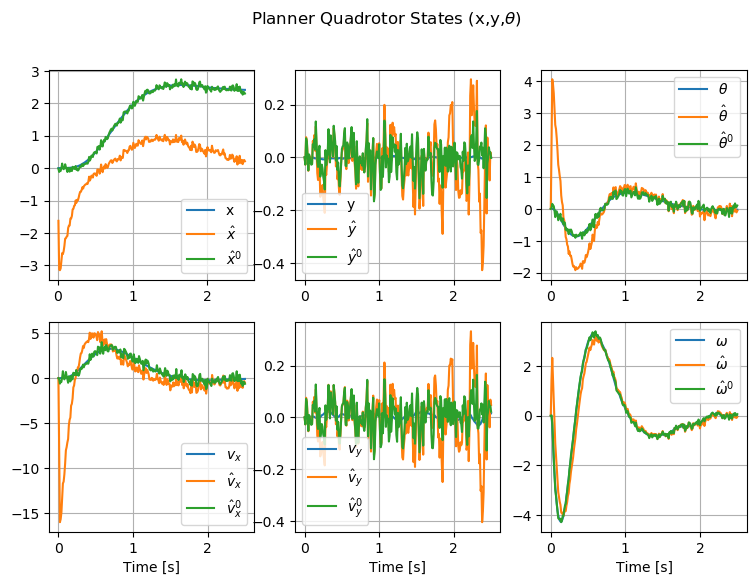

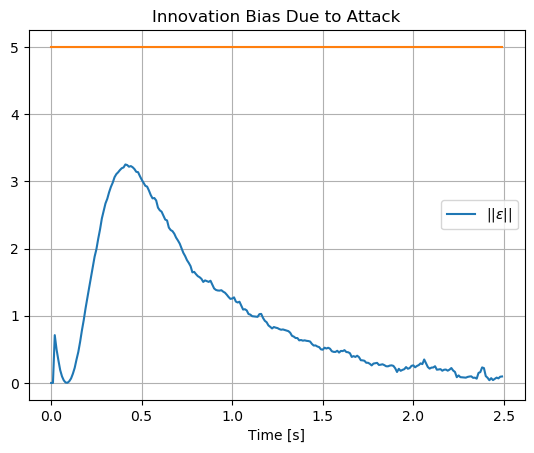

In [219]:
plt.figure(figsize=[9,6])
plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t[1:], state[0,1:])
plt.plot(t[1:], state_est[0,1:])
plt.plot(t[1:], state_est_0[0,1:])
plt.grid()
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_est[2,:])
plt.plot(t, state_est_0[2,:])
plt.grid()
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_est[4,:])
plt.plot(t, state_est_0[4,:])
plt.grid()
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_est[1,:])
plt.plot(t, state_est_0[1,:])
plt.grid()
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_est[3,:])
plt.plot(t, state_est_0[3,:])
plt.grid()
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_est[5,:])
plt.plot(t, state_est_0[5,:])
plt.grid()
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')



# we can also plot the control
plt.figure()
plt.title('Innovation Bias Due to Attack')
plt.plot(t[:-1], np.linalg.norm(C@delta[:,:-1], axis=0)**2)
plt.plot(t[:-1], np.repeat(5, t.shape[0]-1))
plt.grid()
plt.legend(['$||{\epsilon}||$'])
plt.xlabel('Time [s]')
u = -K@x_est
quad.animate(state, u, goal=a_star)

In [74]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])

# Start with a diagonal weighting
Q_ctrl = np.array([[1e0, 0., 0., 0., 0., 0.],
                           [0., 1e0, 0., 0., 0., 0.],
                           [0., 0., 1e0, 0., 0., 0.],
                           [0., 0., 0., 1e0, 0., 0.],
                           [0., 0., 0., 0., 1e0, 0.],
                           [0., 0., 0., 0., 0., 1e0]])

R_ctrl = np.array([[1e2, 0.],
                           [0., 1e2]])

K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

Q_est = np.eye(6)
R_est = np.eye(2)

L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

T = 200
x0 = np.array([0.0, 0., 0., 0., 0, 0.])
x0_est = np.array([0.1, 0., 0., 0., 0, 0.])
x0_est_0 = np.array([0.1, 0., 0., 0., 0, 0.])

t = np.zeros([T+1,])
x = np.empty([6, T+1])
x_est = np.empty([6, T+1])
x[:,0] = x0
x_est[:,0] = x0_est
u = np.zeros([2, T])

x_est_0 = np.empty([6, T+1])
x_est_0[:,0] = x0_est_0
u_0 = np.zeros([2, T])

delta = np.empty([6, T+1])
delta[:,0] = np.zeros(6)

A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
for i in range(T):
    w = 0.01*np.random.randn(6)
    v = 0.01*np.random.randn(2)
    #a += np.array([0.0001*i, 0.0])
    #u[:,i] = -K@(x_est[:,i]) + np.array([quad.m * quad.g / 2, quad.m * quad.g / 2])
    #x[:,i+1] = quad.get_next_state(x[:,i], u[:,i]) + w
    x[:,i+1] = A@x[:,i] - B@K@x_est[:,i] + w
    y = C@x[:,i+1] + v + a[:,i+1] + C@np.array([1.6,0,1.6,0,0,0])
    print(a[:,i+1] + C@(np.eye(6) - A)@np.array([1.6,0,1.6,0,0,0]))
    y_0 = C@x[:,i+1] + v
    
    x_est[:,i+1] = (A - B@K)@x_est[:,i] + L@(y - C@((A- B@K)@x_est[:,i]))
    x_est_0[:,i+1] = A@x_est_0[:,i] - B@K@(x_est[:,i]) + L@(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i])))

    delta[:,i+1] = ((np.eye(6) - L@C)@A - B@K)@delta[:,i] - L@(a[:,i]- np.array([1.6,1.6]))
    
    #x[:,i+1] = (A- B@K)@x[:,i] + w
    t[i+1] = t[i] + 0.01

state = x
state_est = x_est
state_est_0 = x_est_0

[-0.06074849 -0.02837469]
[-0.06465331 -0.11913797]
[-0.07678651 -0.18567496]
[-0.08833671 -0.24678075]
[-0.09819496 -0.30203858]
[-0.10857433 -0.35387663]
[-0.11869867 -0.40097587]
[-0.12913988 -0.44295989]
[-0.13831759 -0.48201966]
[-0.149402   -0.51825729]
[-0.15959549 -0.55040793]
[-0.16867938 -0.58194641]
[-0.17998958 -0.60872081]
[-0.19102109 -0.6330371 ]
[-0.20213086 -0.65512431]
[-0.21324474 -0.67160638]
[-0.22240211 -0.6860515 ]
[-0.23458919 -0.701086  ]
[-0.24647383 -0.71067229]
[-0.25760639 -0.7191741 ]
[-0.26880058 -0.7247864 ]
[-0.2806914  -0.72734058]
[-0.29185899 -0.731697  ]
[-0.3036286  -0.73032821]
[-0.31380307 -0.73082932]
[-0.32604131 -0.73001001]
[-0.33736212 -0.72525406]
[-0.35042198 -0.71919365]
[-0.36175413 -0.71601663]
[-0.37080814 -0.71044619]
[-0.38192969 -0.70539408]
[-0.39177389 -0.69976624]
[-0.40395196 -0.69484181]
[-0.41504878 -0.69091974]
[-0.42326669 -0.68303612]
[-0.43416623 -0.67797696]
[-0.44457392 -0.66918771]
[-0.45289318 -0.66296881]
[-0.46250641

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAG41tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
C1ZliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwAAAwAGIxI3/ofxeM38AAAD
AAC3ABhQDCAKqAvuR9LikjcAByFYb9tQNVb7Nr1qhoK4mZkOlpEotTcK1jrgHtmxaRfE5/x97JD2
gb9ykWfJFXWjj54NWnZt1sncUAriPP+XYADyUEsXPEbQjkYIe53KVOLC7wsMcfGQo5A7K/efA7C9
hW2fpD4821B8mnZV6IZfUi+pom+IiEyQx8eXwg9TnqGv8dNNx3qbY7keg5pZi4NZIFnvgptGDtw/
LcW4eVyElmZml9JhzLaqhn/cImBUlwA/akYuFOfD1oBrzZsETxq5hgAxAO07LWYOvL0a/p+nsAhH
lU0wcbzl1IF9FYsNYoiDV8g2FWm8WHihgBo2cSpMkuYpBUVBToVxgMIfzxme2aHXZrvKs0ICBP0D
qxPW3Kph0wCUGohCoXzOemYo+WzcoV4VwZSwF7jH34VPeo7b+kdaXTDdgkQJGjlNIFBv1bDXyyHM
a7oXAGg6r23a1zYzhXCT8yMyaIyWIpGJ2PjifvDWnDh3mIGfAI95UgaQdM7i5imqjzthZKc4qtQn
hFLEv1bGm0Na7bUM/EDsb5McIAMts1W5O2GFCQ5ScmKvBekrTldkx9u5bdS35D4nPETXN3gv2Lvz
YpU8d8xIMN/dpeKSIGKpBQxHG8H/K43ujm4WOgETC26USmfZan0tugaDOJ24ssNmGV8UjUEU2Rn/
f0xQ+wMCiQekUbgnT+PRswPcxu1VueUAEBAnAAADAAADAAAIsjUyionnv3vwH5mObccfIi16JD/y
l5d9YurenAln/rB0iYLp7PEJnahbrNHNkI7rPrB6o7ew62I9hBzoZQMyelQVViDLH10BaQJU8700
WAwnR/QJQ123axjQl781Qq5KKJ3S/hu2345UkYfmjqna9xqyie5oOjM6KvVLxpOetgMRpLx8qdEh
d7f2v5dcVhX/8Mw2kLqL0C/Y6s1vhAA4qq+cW0WlTCkdBgNXTi5315ZzB1/LjpXPBnJ/yGTp2EaC
CFv6HjsCVIavE499hDhnWvg+vAop2NTrR/joYg1/XRkx8QyobNC1fZDAKf7IBmhcGJWuMxZOebW8
VfPzfyi5+COrIcbCSAAIoC+siOEGmpAAAAMAAAMAAAMAAAMAcrf9e3oy7jSjNsr9XJICKDuaaxFv
pNQ/Qwcsd/FkG9sbsWqNdnyqaiVC9NcivHHX2Acq85zPO7LtEi6OggUWTUrwGGL8pe/oBNnwnRWa
xHsfwVPIxVDvYRLaa1GSPwdUeprMDjdX+LR6JQxVAYWtTTL/4bn/XbzsfOlskcLCrxFjCplb2ktl
hEN0A3nAK4P8iHUsLGbxk/2GbflVXq3qCmc0tNDDC80H+4iUIkk6Ofy7zrzQKzKP2x1Fnq14iXQ9
Z4FRvuLkITxjA1n5CeOYOEPGDLVRRWHrRBHJRj4XP18S6vZfWTj711RdwL5WW6YPKJw7o3xn1Hzb
wJ+Sx9WeVG9jipy/nj6u7cnQcRGccBST/YW/InuBS7W/CN9w0oKKOSFIhhcVKlo9nwwP++/eR99J
kXlqU4r2H+baRjUXp1jmyF3/6gr1bZeNTXdfzNVYLxYCnMhejR69joKT7aclfTjEDcwmSlRBLF3T
FKOKZg8wTMi1afyxDfNeQLZjy/3SK4Bb1LR8E5gkgCi6q0Q4Nje4Vunxyeo8fcUZQUQ4oFWO+OSB
OakkJGfP7Y/ykiyeTWiuv5mFO9h805qo+PnlQHz6/vLTM/ST2FPhRCXDtJ/LL6/K8Big8MqzBje0
pWrTM8SBxi0MzWf12MoOGfY3hnn1nZM4DauqWxsygz6QWJCEOQLMbytXi5X4bQAAQLMAADEDZCBA
zaFKKSSbj+U+38M8RbTWidW6hIu34w0rbLq0qmXODNEghpRA9fBuNQPKgHe6Y00qGSeRyxfYfepu
2XMyOxc4yZ4o9dvj7SVgNT3NdiYWEpTrg3NL3r7dCw4rtKDEefi6VygsaZrEUWg3+KiCGidU8tGe
4rBPTsvbsrE5dPc31ATZBocTVHLbTGemZcEM7a4rrmUDluE7qKFY9wXw7gdoMVHKEupDMF/V/I+X
zDPGX4NTN/7GnSO9QVKlXRjg1/xybH0VO7ef/1t8imigxfgGwELggxJqduIilTf45Eq1xZszfyEf
Z/x4cBa2ZVWxgvEjDHf+c1zgUgadsb/GLsSv51OlznLJho88RgbMCbIRQz63gjXjXUhDZHaz/D6s
3oyNmb4FsSS7T15mAZl8LATvhCS+g/x2zfKM9WMYaV//oCVGg61aoSecj18KG7srIvB/ejeJR/7l
C8OdG1/9sNpLgr09yqBlmgILxBFJ+JdYIfTh//HAL4Sn+CIUBgKY/NHAAJ0AF/ADX+AMTbKFk7wB
GBb+AY4jQxwjoKVRwAAoGZsEuEY7xPUsZEYJmaLYH/GUh40t2bftUScnC2xPrMH95TP4pxS41KFw
+kMC1pvzrX+TB/M07+870S3/Ne6JPi0qc38yLGSATZykkT/ofEkHjSdLf0ehOpgJ+0uT23HxY9xd
1UXDAp4gT0Jd9WJai13Htzv/ClqOYWZ2yfZDqE9H+0PWjWwObfV7B1dcd/GOSHifGBq8oVrq6r14
2wINo6Njogy499qof39Dtx/08uw9TjGzcsEjIIsiTVpxgbuOLLLcPmM7z1kFo3uaoDM+t3VvCHns
iDpu9nd/NBfHY3Dq2/7qyPEDd/8BYpPXZ+zFJeCD5p3F+j4AR7ASV622+753Z5NsCWBllWdaUCev
X5qNYt3SW0yiiNiJDrjn+okXnCWW0of1cVcqjXfF1XGk+aQ6k0p/Ktyj7FVlBsbfGVESfNHQRz8M
P4iOYvcR3vZmTqfqRmKXK

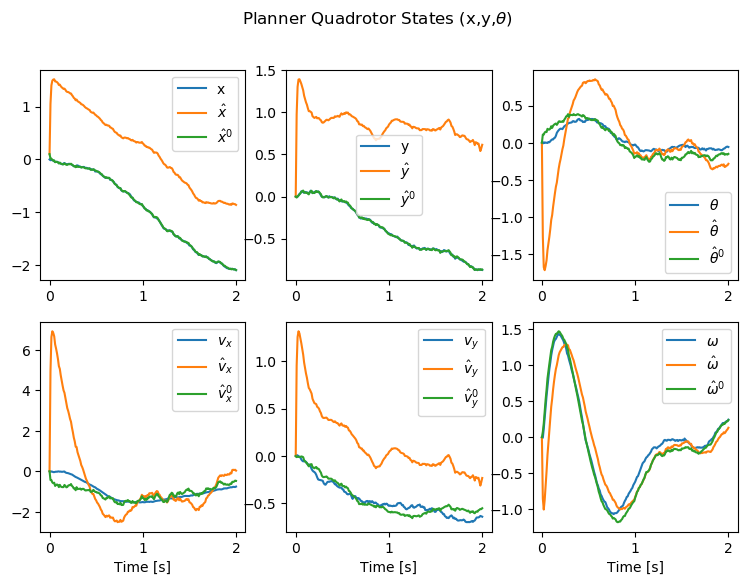

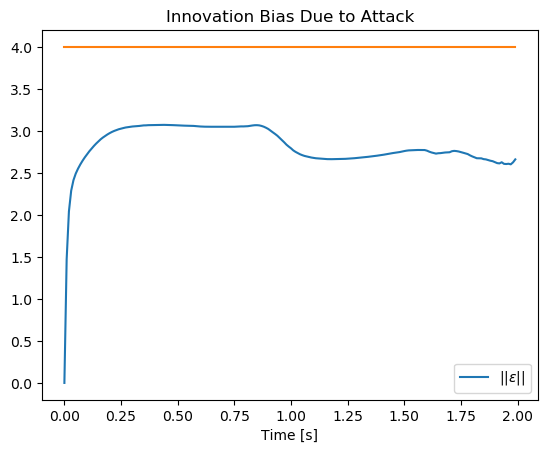

In [76]:
plt.figure(figsize=[9,6])
plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_est[0,:])
plt.plot(t, state_est_0[0,:])
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_est[2,:])
plt.plot(t, state_est_0[2,:])
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_est[4,:])
plt.plot(t, state_est_0[4,:])
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_est[1,:])
plt.plot(t, state_est_0[1,:])
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_est[3,:])
plt.plot(t, state_est_0[3,:])
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_est[5,:])
plt.plot(t, state_est_0[5,:])
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')



# we can also plot the control
plt.figure()
plt.title('Innovation Bias Due to Attack')
plt.plot(t[:-1], np.linalg.norm(-C@delta[:,:-1], axis=0))
plt.plot(t[:-1], np.repeat(4, t.shape[0]-1))
plt.legend(['$||{\epsilon}||$'])
plt.xlabel('Time [s]')
quad.animate(state, u, goal=[1.0,0.0])